# FashionMNIST
Load images from the [Fashion-MNIST data](https://github.com/zalandoresearch/fashion-mnist)


The dataset comprised of 60,000 small square 28x28 pixel grayscale images of items of 10 types of clothing with 0-9 class labels.
class labels:
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

### Load the Fashion-MNIST data
* Use ``torch.utils.data.dataset``
* Data path: data
* Apply transformations to the data (turning all images into Tensor's for training a NN

### Train and CNN to classify images
* Load in both training and test datasets from the FashionMNIST class



## Import the Necessary Packages

In [1]:
# basic torch libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The output of ``torchvision`` are PILImage images of range [0, 1]
* Transform them to Tensor for input into a CNN

In [2]:
# Defin a transform to read the data in as a Tensor
data_transform = transforms.ToTensor()

# Choose the training and test datasets
path = './data'

# Training datasets
train_data = FashionMNIST(root=path,
                          train=True,
                          download=False,
                          transform=data_transform)

# Test datasets
test_data = FashionMNIST(root=path,
                         train=False,
                         download=False,
                         transform=data_transform)



# Print out some stats about the training data
print('Train data, number of images', len(train_data))

# Print out some stats about the training data
print('Test data, number of images', len(test_data))

Train data, number of images 60000
Test data, number of images 10000


## Data iteration and batching
``torch.utils.data.DataLoader`` is an iterator that allows to batch and shuffle the data


In [3]:
# shuffle the data and load in image/label data in batches of size 20
# Depends on large or small size of batch size will affect the loss
batch_size = 20

# load train
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# load test
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Using ``dataiter.next()`` for cell iterates over the training dataset of loaded a random batch image/label data.

Plots the batch of images and labels in a ``2*batch_size/2`` grid.


/home/eightun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


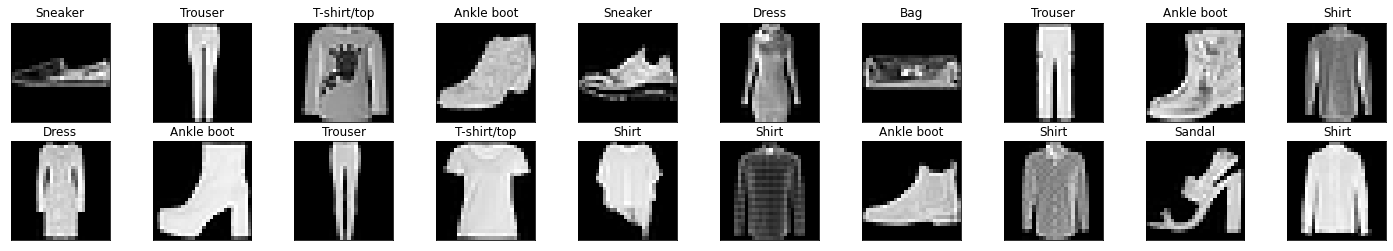

In [4]:
# obtain one batch of training images
# iter
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert to numpy

# plot the images in the batch with labels
fig = plt.figure(figsize=(25, 4)) # fig size
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## View an image
* Normalize
* grayscale image

### Normalization
Normalization ensures that, as we go through a feedforward and then backpropagation step in training our CNN, that each image feature will fall within a similar range of values and not overly activate any particular layer in our network. During the feedfoward step, a network takes in an input image and multiplies each input pixel by some convolutional filter weights (and adds biases!), then it applies some activation and pooling functions. Without normalization, it's much more likely that the calculated gradients in the backpropagaton step will be quite large and cause our loss to increase instead of converge



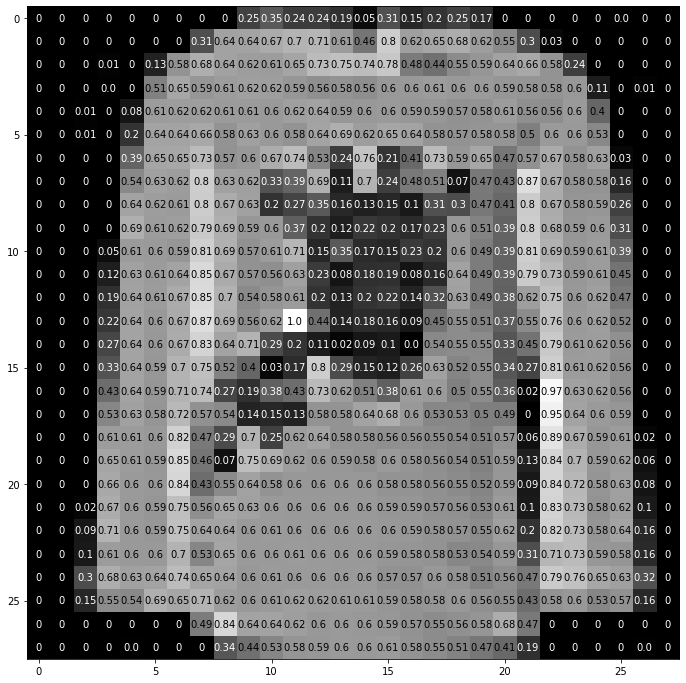

In [5]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])

# display the pixel values in the image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### NN Architecture
* Architecture for simple ConvNet [INPUT-CONV-RELU-POOL-FC]
* [NN Layers](http://pytorch.org/docs/master/nn.html)
* Flattening used for the output of conv/pooling layer to a linear layer. In Keras used ``Flatten()``. In Pytorch used an input x with ``x = x.view(x.size(0), -1)``
* Keep tract output dimension for case ``output_dim = (W-F+2P)/S + 1``
    * Input volume size(W)
    * Receptive field size of the Conv Layer neurons(F)
    * The sride with which applied(S)
    * The amount of zero padding used(P)

* Dropout randomly turns off perceptrons(nodes). It gives a way to balance network so that every node works equally towards the same goal, and if one makes a mistake, it won't dominate the behavior of our model. ``nn.Dropout()``

We set dropout p = 0.9 which means each epoch, each nodes get turned off with a probabilit 90percent.


# Necessary Packages for NN Module

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# Define Layers of a model
# Will use [INPUT-CONV-RELU-POOL-CONV-RELU-POOL-FC]
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel(grayscale), 10 output channels/features maps
        # Applies a 2D convolution over an input signal composed of several input planes.
        # 3x3 square convolution kernel
        # output_dim = (28-3)/1 + 1 = 26
        # output Tensor for one image will have the dimensions: (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer with kernel_size=2, stride=2
        # Output_dim = 26/2 = 13
        # output Tensor for one image will have the dimensions: (10, 13, 13)
        self.pool = nn.MaxPool2d(2,2)
        
        # Apply Second conv layer: 10 inputs, 20 outputs
        # 3x3 square convolution kernel
        # output_dim = (13-3)/1 + 1 = 11
        # output Tensor for one image will have the dimensions: (20, 11, 11)
        self.conv2 = nn.Conv2d(10, 20, 3)
        # Outpu_dim for pooling after secon conv (20, 5, 5); 5.5 is rounded down
        
        ######
        # FC
        # # 20 outputs * the 5*5 filtered/poled map size
        # # 10 output channels (for the 10 classes)
        # self.fc1 = nn.Linear(20*5*5, 10)
        # pool 10 -> 50
        self.fc1 = nn.Linear(20*5*5, 50)
        ######
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)
        ######
        
        
    # feedforward behavior
    def forward(self, x):
        # Apply [CONV-RELU-POOL-CONV-RELU-POOL]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flattening used for the output of conv/pooling layer to a linear laye
        # Flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # One linear layer
        x = F.relu(self.fc1(x))
        
        # # Apply softmax layer to convert the 10 outputs (0-9) into a distribution prob of class scores
        # x = F.log_softmax(x, dim=1)
        ####
        # two linear layers with dropout in between
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        ####
        
        return x
    
        
        

In [8]:
# Instantiate and print Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Loss function and Optimizer

* Loss function typically uses cross entropy loss ``criterion = nn.CrossEntropyLoss()``; Cross entropy loss combines softmax and NLL loss (``nn.NLLLoss()``).
* NLL Loss being uesd for the output of Net is a distribution of class scores which this condtion fit to the model.

* Some standard stochastic optimizers are stochastic gradient descent and Adam.

* Apply momentum. It helps to find and then move on from local minimums and find the global minimum

In [9]:
# additional necessary package for optimizer
import torch.optim as optim

# # Apply NLL Loss for distribution of class scores
# criterion = nn.NLLLoss()
####
# using cross entropy which combines sftmax and NLL loss
criterion = nn.CrossEntropyLoss()

# Optimizer used SGD with small learning rate 0.001
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

####

# Accuracy before training
* The accuracy of before and after training hepls to see the differnce whether netwrok has learned something.

In [10]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:
    
    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # count up total number of correct labels for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
# calculate the accuracy to convert correct from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

print('Accuracy before training: ', accuracy)

Accuracy before training:  11.76


# Train the Network
* n_epochs: The number of epochs how many times a netwrok will cycle through the entire training dataset
* Loop over the training dataset in batches and record the loss every 1000 batches
* Steps:
    * Zero's the gradients to prepare for a forward pass
    * Passes the input through the network(forward pass
    * Computes the loss
    * Propagates gradients back into the netorks' parameter(backward pass)
    * Updates the weight(parameter update
    * print calculated loss

In [11]:
def train(n_epochs):
    # collect loss as the network trains
    loss_over_time = []
    
    # loop over the dataset
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # Zero the parameter(weight) gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = net(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # backward pass o calculate the parameter gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            #Print loss stat to convert loss into a scalar and add it to running_loss, here used .item()
            running_loss += loss.item()

            # show stat at every 1000 batches
            if batch_i % 1000 == 999:
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [12]:
# define the number of epochs to train for
# start with small epochs to see if model works initially
n_epochs = 30

# call train and record the loss over time
training_loss = train(n_epochs)




/home/eightun/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Epoch: 1, Batch: 1000, Avg. Loss: 1.8400431061387061
Epoch: 1, Batch: 2000, Avg. Loss: 0.9361596993207931
Epoch: 1, Batch: 3000, Avg. Loss: 0.8101325169205665
Epoch: 2, Batch: 1000, Avg. Loss: 0.7249000519216061
Epoch: 2, Batch: 2000, Avg. Loss: 0.6920741278529167
Epoch: 2, Batch: 3000, Avg. Loss: 0.6510990876704454
Epoch: 3, Batch: 1000, Avg. Loss: 0.6185019191503525
Epoch: 3, Batch: 2000, Avg. Loss: 0.6127123100161552
Epoch: 3, Batch: 3000, Avg. Loss: 0.5829089113175869
Epoch: 4, Batch: 1000, Avg. Loss: 0.5740561997294426
Epoch: 4, Batch: 2000, Avg. Loss: 0.5605625699460507
Epoch: 4, Batch: 3000, Avg. Loss: 0.5485085655003786
Epoch: 5, Batch: 1000, Avg. Loss: 0.5394243684932589
Epoch: 5, Batch: 2000, Avg. Loss: 0.5287500197440386
Epoch: 5, Batch: 3000, Avg. Loss: 0.5229253826737403
Epoch: 6, Batch: 1000, Avg. Loss: 0.5081946065053343
Epoch: 6, Batch: 2000, Avg. Loss: 0.4969275861084461
Epoch: 6, Batch: 3000, Avg. Loss: 0.49857653281092645
Epoch: 7, Batch: 1000, Avg. Loss: 0.482163142

# Visualize the Loss
print recorded avg loss for each 1000 batches and for each epoch

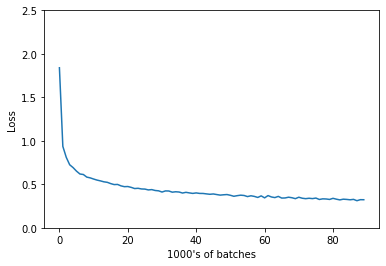

In [13]:
# Visualize the Loss
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('Loss')
plt.ylim(0, 2.5)
plt.show()
           

As shown above plot shows the loss decreases over time.

It takes a little bot for big initial loss decrease, and the loss is flattening out over time

# Test the Trained Network
* Test trained model on a previously unseen dataset
* Use training images (good modle should reach greater than 85% accuracy on this test dataset)

In [14]:
# Initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)
    
    # calcuate the loss
    loss = criterion(outputs, labels)
    
    # update avg test loss
    test_loss += ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum valuein the output list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare prediction to true label
    # this creates a correct Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        
        # get the scalar value of correct items for a class, by calling 'correct[i].item()'
        class_correct[label] += correct[i].item()
        
        class_total[label] += 1
        
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i],
                                                         100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]),
                                                         np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %(100. * np.sum(class_correct) / np.sum(class_total),
                                                     np.sum(class_correct),
                                                     np.sum(class_total)))

Test Loss: 0.309656

Test Accuracy of T-shirt/top: 79% (797/1000)
Test Accuracy of Trouser: 96% (965/1000)
Test Accuracy of Pullover: 76% (764/1000)
Test Accuracy of Dress: 90% (907/1000)
Test Accuracy of  Coat: 85% (851/1000)
Test Accuracy of Sandal: 96% (964/1000)
Test Accuracy of Shirt: 71% (717/1000)
Test Accuracy of Sneaker: 96% (966/1000)
Test Accuracy of   Bag: 97% (972/1000)
Test Accuracy of Ankle boot: 95% (957/1000)

Test Accuracy (Overall): 88% (8860/10000)


# Visualize sample test results
Shows predicted class(true class)

/home/eightun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


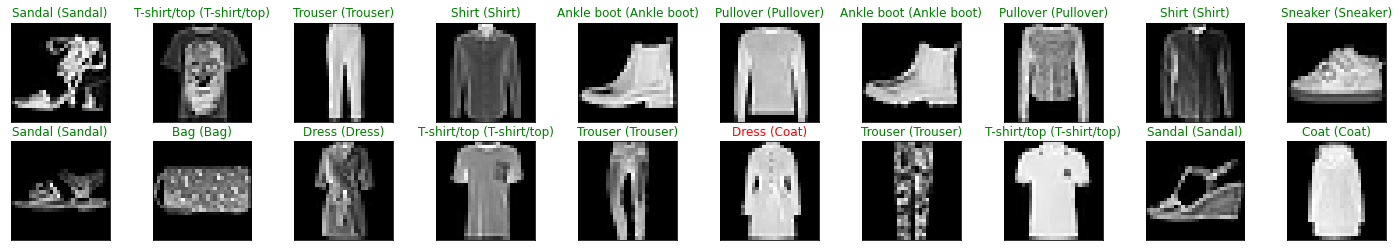

In [15]:
# obtan one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=('green' if preds[idx]==labels[idx] else 'red'))

# After add dropout and momentum

### The [Previous model](https://github.com/bmaxdk/NN-PyTorch/blob/main/04_Fashion_MNIST_Training/FashionMNIST_Training.ipynb) has Weaknesses:

Test Accuracy of Dress:  0% ( 0/1000)

As a result this two have 0% accuracy. Due o incorrectly classifies most of other which has a similar overall shape. We can add regularization.

Dropout layers to avoid overfitting certain classes at the cost of generalization.

### Dropou layers and adding momentum help to improve the [Previous model](https://github.com/bmaxdk/NN-PyTorch/blob/main/04_Fashion_MNIST_Training/FashionMNIST_Training.ipynb) 

# Save the model

In [16]:
# path and model name
model_dir = 'saved_models/'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the directoy 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)